In [1]:
from __future__ import absolute_import, division

import os
import urllib, cStringIO

import pymongo as pm

import numpy as np
import scipy.stats as stats
import pandas as pd
import json
import re

from PIL import Image
import base64
import sys

import matplotlib
from matplotlib import pylab, mlab, pyplot
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import seaborn as sns
sns.set_context('talk')
sns.set_style('darkgrid')

from IPython.display import clear_output

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

### setting up paths


In [2]:
# directory & file hierarchy
proj_dir = os.path.abspath('../..')
analysis_dir = os.getcwd()
results_dir = os.path.join(proj_dir,'results')
plot_dir = os.path.join(results_dir,'plots')
features_dir= os.path.join(results_dir,'features')
exp_dir = os.path.abspath(os.path.join(proj_dir,'experiments'))
sketch_dir = os.path.abspath(os.path.join(proj_dir,'sketches'))

## add helpers to python path
if os.path.join(proj_dir,'analysis') not in sys.path:
    sys.path.append(os.path.join(proj_dir,'analysis'))

if not os.path.exists(results_dir):
    os.makedirs(results_dir)  

if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)   
    
if not os.path.exists(csv_dir):
    os.makedirs(csv_dir)  

if not os.path.exists(features_dir):
    os.makedirs(features_dir)
    
## add helpers to python path
if os.path.join(proj_dir,'analysis') not in sys.path:
    sys.path.append(os.path.join(proj_dir,'analysis'))        
    
# Assign variables within imported analysis helpers
import analysis_helpers as h
if sys.version_info[0]>=3:
    from importlib import reload
reload(h)

<module 'analysis_helpers' from '/Users/judithfan/semantic_parts/analysis/analysis_helpers.pyc'>

#### helpers

In [142]:
def cleanup_df(X):
    if 'Unnamed: 0' in X.columns:
        X = X.drop(columns=['Unnamed: 0'])
    return X

def flatten(x):
    return [item for sublist in x for item in sublist]

In [215]:
## helper dictionaries 
OBJECT_TO_CATEGORY = {
    'basset': 'dog', 'beetle': 'car', 'bloodhound': 'dog', 'bluejay': 'bird',
    'bluesedan': 'car', 'bluesport': 'car', 'brown': 'car', 'bullmastiff': 'dog',
    'chihuahua': 'dog', 'crow': 'bird', 'cuckoo': 'bird', 'doberman': 'dog',
    'goldenretriever': 'dog', 'hatchback': 'car', 'inlay': 'chair', 'knob': 'chair',
    'leather': 'chair', 'nightingale': 'bird', 'pigeon': 'bird', 'pug': 'dog',
    'redantique': 'car', 'redsport': 'car', 'robin': 'bird', 'sling': 'chair',
    'sparrow': 'bird', 'squat': 'chair', 'straight': 'chair', 'tomtit': 'bird',
    'waiting': 'chair', 'weimaraner': 'dog', 'white': 'car', 'woven': 'chair',
}
CATEGORY_TO_OBJECT = {
    'dog': ['basset', 'bloodhound', 'bullmastiff', 'chihuahua', 'doberman', 'goldenretriever', 'pug', 'weimaraner'],
    'car': ['beetle', 'bluesedan', 'bluesport', 'brown', 'hatchback', 'redantique', 'redsport', 'white'],
    'bird': ['bluejay', 'crow', 'cuckoo', 'nightingale', 'pigeon', 'robin', 'sparrow', 'tomtit'],
    'chair': ['inlay', 'knob', 'leather', 'sling', 'squat', 'straight', 'waiting', 'woven'],
}

#### load in data

In [163]:
## loading in files we need
feature_df = cleanup_df(pd.read_csv(os.path.join(features_dir,'semantic_parts_sketch_features_compressed.csv')))
meta_df = cleanup_df(pd.read_csv(os.path.join(features_dir,'semantic_parts_sketch_meta.csv')))

In [164]:
## concatenate meta and features to enable easy subsetting of dataframe
F = pd.concat((meta_df,feature_df),axis=1)

In [165]:
## aggregate by target and condition and take the mean across rows within each group
F2 = F.groupby(['target','condition']).mean().reset_index()

In [183]:
## construct dictionary of object to part labels

## version where each part label within category is treated distinctly
part_dict_expanded = {'bird': ['beak', 'body', 'eye', 'feet', 'head', 'leg', 'tail', 'wing'], \
                     'car': ['body.1', 'bumper', 'door', 'headlight', 'hood', 'trunk', 'wheel', 'window', 'windshield'],\
                     'chair': ['armrest', 'backrest', 'leg.1', 'seat'], \
                     'dog': ['body.2', 'ear', 'eye.1', 'head.1', 'leg.2', 'mouth', 'neck', 'paw', 'tail.1']}

## version where each repeating part labels within category are not distinguished
part_dict_compressed = {'bird': ['beak', 'body', 'eye', 'feet', 'head', 'leg', 'tail', 'wing'], \
                     'car': ['body', 'bumper', 'door', 'headlight', 'hood', 'trunk', 'wheel', 'window', 'windshield'],\
                     'chair': ['armrest', 'backrest', 'leg', 'seat'], \
                     'dog': ['body', 'ear', 'eye', 'head', 'leg', 'mouth', 'neck', 'paw', 'tail']}

## abbreviated handles 
pde = part_dict_expanded
pdc = part_dict_compressed

In [184]:
## re-label the columns feature df that represent numstrokes to contain word 'numstrokes'
part_list = []
for key in pdc.keys():
    part_list.append(pdc[key])
part_list = list(np.unique(flatten(part_list)))

In [185]:
## rename numstroke columns 
for this_part in part_list:
    F2.rename(columns={this_part:'{}_numstrokes'.format(this_part)}, inplace=True)

In [186]:
## add arclength feature to set of columns associated with this category
def add_arclength_cols(part_dict):    
    for category in part_dict.keys():
        part_dict[category] = [i + '_numstrokes' for i in part_dict[category]] + \
                              [i + '_total_arclength' for i in part_dict[category]]
    return part_dict

In [187]:
## now actually add arc length columns to the list of columns considered by the 
pdc = add_arclength_cols(pdc)
pde = add_arclength_cols(pde)

In [220]:
## re-add category back to the F2 dataframe so we can subset on that later
F2['category'] = F2['target'].apply(lambda x: OBJECT_TO_CATEGORY[x])

In [221]:
## get inds for subsetting dataframe
close_inds = F2['condition'] == 'closer'
far_inds = F2['condition'] == 'further'

category_inds = F2['category']=='bird'

obj_list = np.unique(F2.target.values)
obj_inds = F2['target']=='tomtit'

In [193]:
## extract particular row corresponding to this object in each condition
f = F2[(far_inds) & obj_inds][pdc['bird']].reset_index(drop=True)
c = F2[(close_inds) & obj_inds][pdc['bird']].reset_index(drop=True)

In [231]:
## extract particular row corresponding to this object in each condition
f = F2[(category_inds) & (far_inds)][pdc['bird']].reset_index(drop=True)
c = F2[(category_inds) & (close_inds)][pdc['bird']].reset_index(drop=True)

In [234]:
diff = c.sub(f)

In [235]:
diff

,beak_numstrokes,body_numstrokes,eye_numstrokes,feet_numstrokes,head_numstrokes,leg_numstrokes,tail_numstrokes,wing_numstrokes,beak_total_arclength,body_total_arclength,eye_total_arclength,feet_total_arclength,head_total_arclength,leg_total_arclength,tail_total_arclength,wing_total_arclength
0,1.330882,0.812500,0.507353,-0.069853,1.099265,-0.187500,0.165441,0.279412,77.797794,35.327206,11.687500,-15.621324,101.647059,-67.794118,32.102941,40.216912
1,1.070588,-0.129412,0.141176,-0.400000,0.282353,1.000000,0.282353,0.082353,65.188235,-150.082353,1.294118,141.988235,164.258824,46.200000,22.717647,-7.270588
2,-0.009524,1.114286,-0.038095,0.266667,0.133333,0.542857,0.180952,0.600000,3.180952,12.704762,4.200000,-62.123810,-0.314286,19.990476,28.752381,184.723810
3,0.445378,0.542017,0.613445,0.466387,1.218487,-0.352941,0.663866,0.386555,13.747899,52.516807,-4.554622,25.529412,160.861345,-46.201681,63.163866,56.063025
4,0.441558,0.889610,1.331169,0.785714,-0.103896,0.168831,0.402597,2.857143,26.461039,142.428571,66.584416,59.766234,-42.493506,-121.779221,40.974026,164.168831
5,-0.238095,0.126984,-0.095238,0.595238,1.007937,-0.095238,-0.063492,1.190476,-6.047619,-83.023810,-6.761905,33.928571,412.642857,72.214286,-9.865079,227.849206
6,0.578947,1.322368,-0.098684,0.325658,0.434211,0.171053,0.039474,1.049342,58.480263,17.842105,-1.190789,-32.407895,98.115132,33.898026,21.148026,44.723684
7,0.523810,1.349206,0.079365,0.507937,1.460317,-0.841270,0.222222,1.666667,34.253968,1.142857,3.000000,16.079365,132.984127,-50.968254,47.746032,126.746032


In [263]:
assert np.vstack((np.array(c),np.array(f))).shape == (16, 16)

In [264]:
fmat = np.vstack((np.array(c),np.array(f)))

In [265]:
def normalize(X):
    X = X - X.mean(0)
    X = X / np.maximum(X.std(0), 1e-5)
    return X

In [266]:
fmat = normalize(fmat)

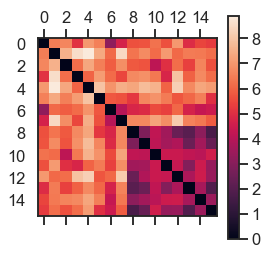

In [267]:
from sklearn.metrics import *
sns.set_style('white')
D = pairwise_distances(fmat,metric='euclidean')
plt.matshow(D)
plt.colorbar()

In [262]:
fmat.std(1)

array([0.9128148 , 1.37886504, 1.09996825, 1.03772605, 1.22489882,
       1.12874522, 0.79791233, 1.15215666, 0.51056247, 0.46126497,
       0.81097176, 0.70506223, 0.86181085, 0.53817208, 0.58134567,
       0.46828113])